In [1]:
import pmm 

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

def real_u(x):
    return  (1/ (2* np.pi**2))*((np.sin(np.pi * x))**2)

def Wendland_kern(x1, x2, epsilon = 0.001): #kernel, use Wendland covariance as an example 
        return np.max(1 - np.abs(x1 - x2)/epsilon, 0)**4 * (4*np.abs(x1 - x2)/epsilon + 1)

def gauss_kernel(x1, x2, L=0.25):
    return np.exp(- (x1-x2)**2 / (2* L**2))

def gauss_kernel_derix(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (-(x1 - x2) / L**2)

def gauss_kernel_deriy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * ((x1 - x2) / L**2)

def gauss_kernel_derixy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * (-(x1-x2)**2  + L**2)

def gauss_kernel_derixx(x1, x2, L=0.25): #This is A operator 
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * ((x1-x2)**2  - L**2)

def gauss_kernel_deriyy(x1, x2, L=0.25): #This is A_hat operator 
    return gauss_kernel_derixx(x1, x2, L) 

#AA_hat operator
def gauss_kernel_derixxyy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**8) *(3* (L**4) - 6* (L**2)*((x1-x2)**2) + (x1-x2)**4)

g1 =  lambda x: np.cos(2*np.pi*x)
b1 = lambda x: 0

d1, d2 = 0, 1
D = [0, 1]

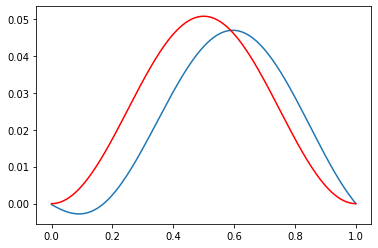

In [2]:
poisson = pmm.PMM(g1, b1, gauss_kernel_derixx, gauss_kernel, gauss_kernel_deriyy, gauss_kernel, 0, 1, D, gauss_kernel, gauss_kernel_derixxyy, gauss_kernel_derixx, gauss_kernel_deriyy, gauss_kernel)

N = 200
X = [(1/N)*i for i in range(N)]
mean1, var1 = poisson.posterior(X, 10, 2)

# compare the mean of multivariate normal with true solution 
plt.plot(np.linspace(0, 1, N),  mean1)
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()

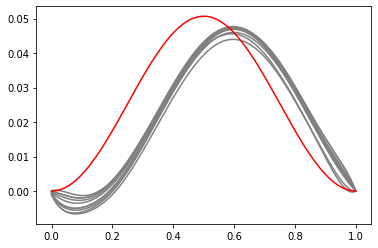

In [3]:
sample = np.random.multivariate_normal(mean1, var1, size=10)
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()

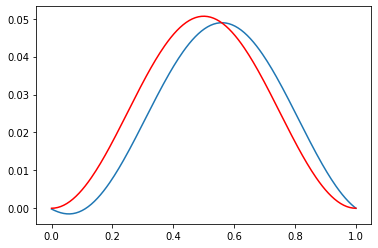

In [4]:
mean2, var2 = poisson.posterior(X, 16, 2)

plt.plot(np.linspace(0, 1,  N),  mean2)
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()

<ipython-input-5-ace28e79384a>:1: RuntimeWarning: covariance is not positive-semidefinite.
  sample = np.random.multivariate_normal(mean2, var2, size=10)


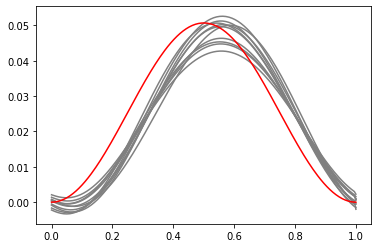

In [5]:
sample = np.random.multivariate_normal(mean2, var2, size=10)
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()